# **Modelo predictivo de la demanda a nivel de categoría de producto: Caso Walmart**
### **Autor:** Andrés Ulloa J.

## **Importar librerías**

In [3]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import itertools
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import joblib

import warnings
warnings.filterwarnings("ignore")

## **Cargar conjunto de datos**

In [5]:
# Cargar conjunto de datos a nivel de categoría
df_foods_agg = pd.read_csv("df_foods_agg.csv")

In [6]:
# Convertir la columna 'date' a tipo datetime.
df_foods_agg['date'] = pd.to_datetime(df_foods_agg['date'])

In [7]:
df_foods_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1097 non-null   datetime64[ns]
 1   sales_total              1097 non-null   int64         
 2   sell_price               1097 non-null   float64       
 3   snap_CA                  1097 non-null   int64         
 4   sales_lag_1              1097 non-null   float64       
 5   sales_lag_2              1097 non-null   float64       
 6   month                    1097 non-null   int64         
 7   week_of_year             1097 non-null   int64         
 8   sales_moving_avg         1097 non-null   float64       
 9   price_promo_interaction  1097 non-null   float64       
 10  cumulative_sales         1097 non-null   int64         
 11  day_of_week              1097 non-null   int64         
 12  price_volatility         1097 non-

In [8]:
df_foods_agg.head(15)

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
0,2013-05-22,2269,3.291816,0,2269.0,2269.0,5,21,2269.000000,0.000000,2269,2,0.000363,2
1,2013-05-23,2466,3.291816,0,2269.0,2269.0,5,21,2367.500000,0.000000,4735,3,0.000000,2
2,2013-05-24,3010,3.291816,0,2466.0,2269.0,5,21,2581.666667,0.000000,7745,4,0.000000,2
3,2013-05-25,3182,3.291830,0,3010.0,2466.0,5,21,2731.750000,0.000000,10927,5,0.000007,2
4,2013-05-26,2976,3.291830,0,3182.0,3010.0,5,21,2908.500000,0.000000,13903,6,0.000008,2
5,2013-05-27,2985,3.291830,0,2976.0,3182.0,5,22,3038.250000,0.000000,16888,0,0.000007,2
6,2013-05-28,2300,3.291830,0,2985.0,2976.0,5,22,2860.750000,0.000000,19188,1,0.000000,2
7,2013-05-29,2110,3.291830,0,2300.0,2985.0,5,22,2592.750000,0.000000,21298,2,0.000000,2
8,2013-05-30,2321,3.291830,0,2110.0,2300.0,5,22,2429.000000,0.000000,23619,3,0.000000,2
9,2013-05-31,3095,3.291830,0,2321.0,2110.0,5,22,2456.500000,0.000000,26714,4,0.000000,2


## **Exploración de datos**

Vamos a partir por una breve descripción de las variables contenidas en el conjunto de datos:

In [11]:
df_foods_agg.describe()

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
count,1097,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1.097000e+03,1097.000000,1097.000000,1097.000000
mean,2014-11-21 00:00:00,2992.652689,3.321885,0.328168,2990.776664,2989.396536,6.520510,26.679125,2990.506761,1.090098,1.667803e+06,3.004558,0.000363,2.507748
min,2013-05-22 00:00:00,0.000000,3.286688,0.000000,0.000000,0.000000,1.000000,1.000000,1808.750000,0.000000,2.269000e+03,0.000000,0.000000,1.000000
25%,2014-02-20 00:00:00,2504.000000,3.294071,0.000000,2503.000000,2497.000000,4.000000,14.000000,2691.500000,0.000000,8.482290e+05,1.000000,0.000000,2.000000
50%,2014-11-21 00:00:00,2856.000000,3.319304,0.000000,2854.000000,2853.000000,7.000000,27.000000,3007.500000,0.000000,1.689361e+06,3.000000,0.000000,3.000000
75%,2015-08-22 00:00:00,3460.000000,3.347954,1.000000,3459.000000,3458.000000,10.000000,40.000000,3279.750000,3.293709,2.496780e+06,5.000000,0.000400,4.000000
max,2016-05-22 00:00:00,5016.000000,3.358232,1.000000,5016.000000,5016.000000,12.000000,53.000000,4370.000000,3.355518,3.282940e+06,6.000000,0.005818,4.000000
std,NaN,666.417384,0.024975,0.469760,665.553817,665.479273,3.449292,15.126988,413.109489,1.560500,9.439479e+05,1.999767,0.000760,1.117293


In [12]:
df_foods_agg.corr()

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
date,1.000000,-0.117743,0.925863,-0.001839,-0.119350,-0.119534,-0.142656,-0.127720,-0.191635,0.002972,0.999873,0.002373,-0.031015,-0.137969
sales_total,-0.117743,1.000000,-0.096408,0.223512,0.531991,-0.056544,0.021395,-0.009274,0.433014,0.222695,-0.117913,0.613259,0.359478,0.029227
sell_price,0.925863,-0.096408,1.000000,-0.003216,-0.097014,-0.098459,-0.089833,-0.069806,-0.157731,0.001920,0.927076,0.002304,-0.000599,-0.088265
snap_CA,-0.001839,0.223512,-0.003216,1.000000,0.202785,0.169360,-0.004158,-0.046928,0.285053,0.999959,-0.001944,-0.011306,0.014145,-0.004849
sales_lag_1,-0.119350,0.531991,-0.097014,0.202785,1.000000,0.531633,0.023194,0.002924,0.808793,0.202058,-0.119076,-0.057568,0.358374,0.028635
sales_lag_2,-0.119534,-0.056544,-0.098459,0.169360,0.531633,1.000000,0.028497,0.014052,0.808298,0.168710,-0.119246,-0.590975,0.011168,0.036152
month,-0.142656,0.021395,-0.089833,-0.004158,0.023194,0.028497,1.000000,0.956402,0.041288,-0.004544,-0.136299,-0.009736,-0.085163,0.971409
week_of_year,-0.127720,-0.009274,-0.069806,-0.046928,0.002924,0.014052,0.956402,1.000000,0.011758,-0.047147,-0.121572,-0.000856,-0.075687,0.934459
sales_moving_avg,-0.191635,0.433014,-0.157731,0.285053,0.808793,0.808298,0.041288,0.011758,1.000000,0.283963,-0.191472,-0.238248,0.179703,0.056155
price_promo_interaction,0.002972,0.222695,0.001920,0.999959,0.202058,0.168710,-0.004544,-0.047147,0.283963,1.000000,0.002875,-0.011346,0.014410,-0.005218


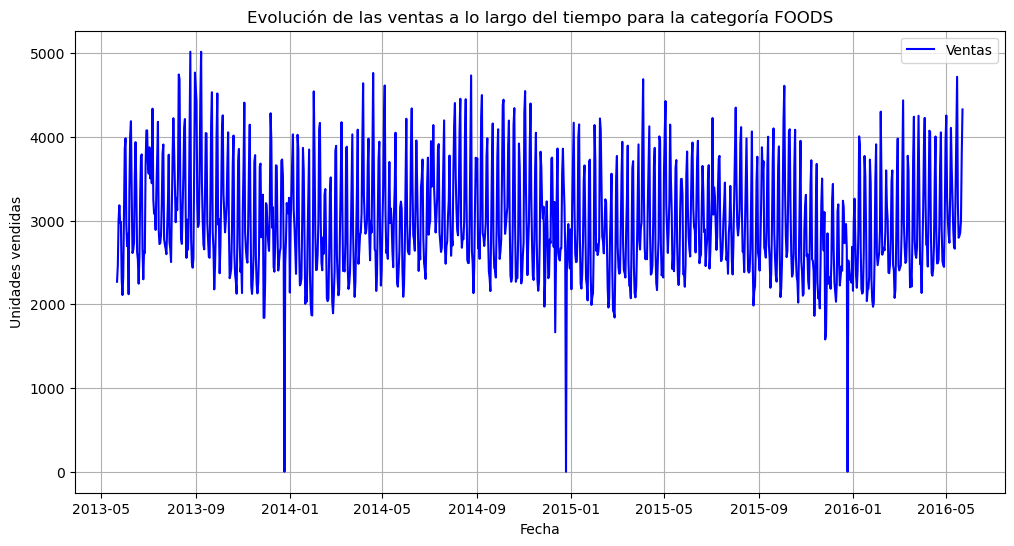

In [13]:
plt.figure(figsize=(12, 6))

# Grafica de ventas diarias
plt.plot(df_foods_agg['date'], df_foods_agg['sales_total'], label='Ventas', color='blue')

plt.title('Evolución de las ventas a lo largo del tiempo para la categoría FOODS')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.show()

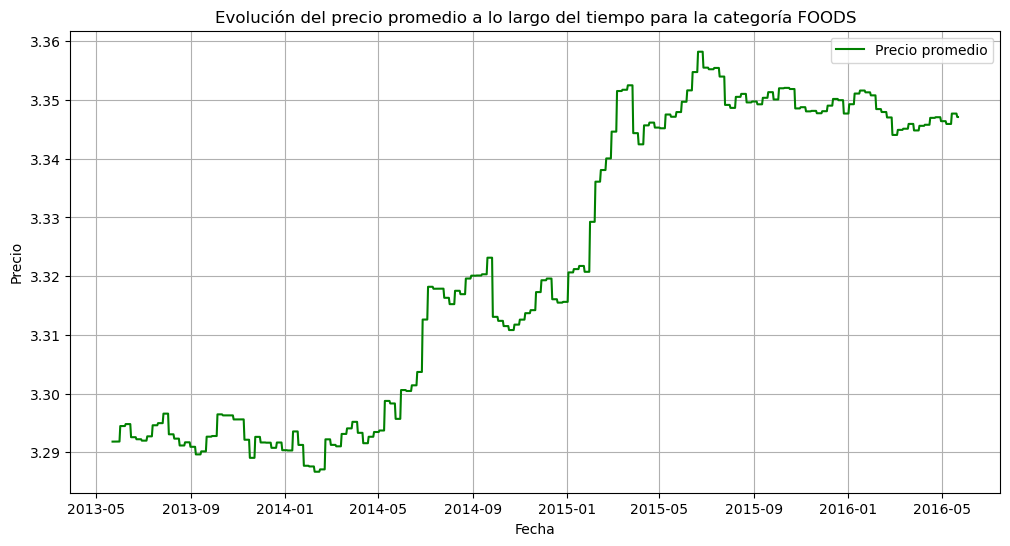

In [14]:
plt.figure(figsize=(12, 6))

# Grafica del precio
plt.plot(df_foods_agg['date'], df_foods_agg['sell_price'], label='Precio promedio', color='green')

plt.title('Evolución del precio promedio a lo largo del tiempo para la categoría FOODS')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

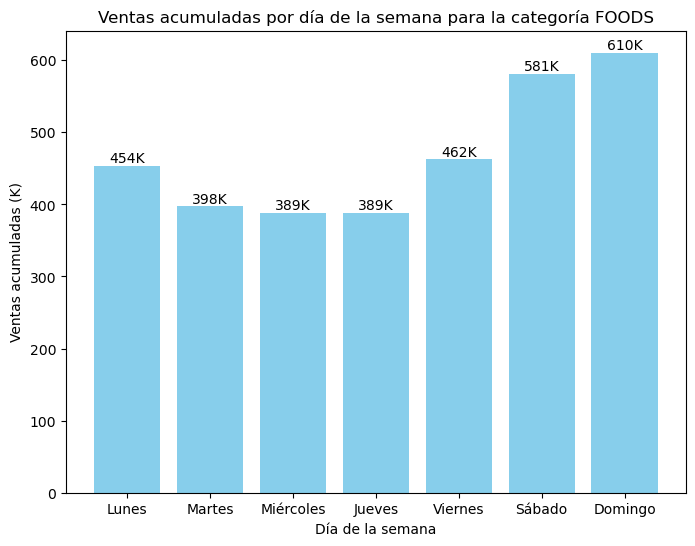

In [15]:
# Agrupamos las ventas por día de la semana
sales_by_day = df_foods_agg.groupby('day_of_week')['sales_total'].sum()

# Definimos los nombres de los días de la semana
days = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

plt.figure(figsize=(8, 6))

# Graficamos las ventas acumuladas por día de la semana
bars = plt.bar(days, sales_by_day / 1000, color='skyblue')  # Dividimos entre 1000 para representar en miles (K)

# Agregamos etiquetas en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}K', ha='center', va='bottom')

plt.title('Ventas acumuladas por día de la semana para la categoría FOODS')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas acumuladas (K)')
plt.show()

## **Primer modelo predictivo LightGBM a nivel de categoría (foods)**

In [17]:
# Establecer la columna 'date' como índice
df_foods_agg.set_index('date', inplace=True)

In [18]:
# Paso 1: Definir la variable objetivo y las características
target = 'sales_total'
features = df_foods_agg.columns.drop(target)

In [19]:
# Paso 2: Dividir los datos en entrenamiento y prueba (últimos 12 meses para test)
test_size = 365  # Últimos 12 meses
train = df_foods_agg.iloc[:-test_size]  # Todo menos los últimos 12 meses para entrenamiento
test = df_foods_agg.iloc[-test_size:]   # Los últimos 12 meses para prueba

In [20]:
# Features y variable objetivo
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [21]:
# Paso 3: Preparar los datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [22]:
# Paso 4: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 300, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}

In [23]:
# Paso 5: Crear el modelo LightGBM con el envoltorio de Scikit-Learn
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)  # Silenciar LightGBM

In [24]:
# Paso 6: Configurar la búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model_lgb, 
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Validación cruzada
    verbose=0,  # Evitar mensajes durante la optimización
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar
)

In [25]:
# Paso 7: Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_esti...
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

In [26]:
# Ver los mejores hiperparámetros encontrados
print(f'Mejores hiperparámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'subsample': 0.6, 'reg_lambda': 0.4444444444444444, 'reg_alpha': 0.7777777777777777, 'num_leaves': 30, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.10666666666666666, 'colsample_bytree': 1.0}


In [27]:
# Paso 8: Entrenar el modelo con los mejores hiperparámetros
best_model = random_search.best_estimator_

In [28]:
# Paso 9: Hacer predicciones con el conjunto de prueba
predicciones = best_model.predict(X_test)

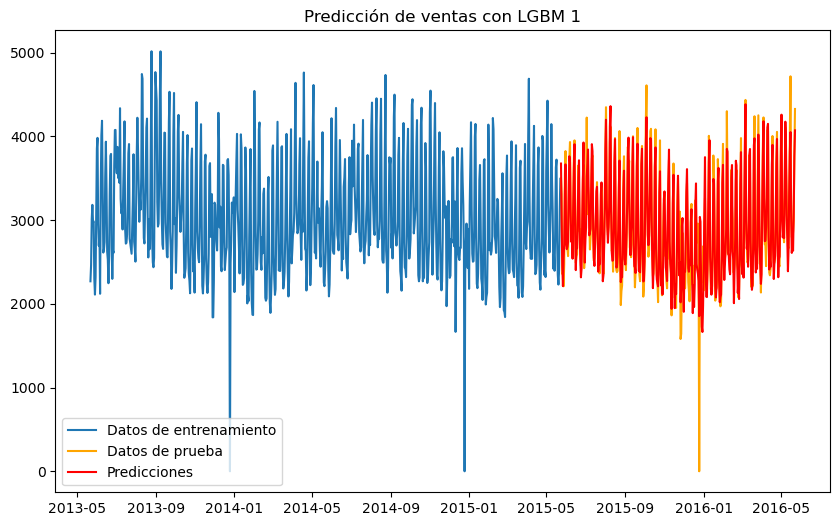

In [29]:
# Graficar los resultados: Datos de entrenamiento, prueba y predicciones
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones del modelo
plt.plot(test.index, predicciones, label='Predicciones', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas con LGBM 1')
plt.legend()
plt.show()

In [30]:
# Paso 10: Evaluar el rendimiento del modelo
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 164.24033076751152
RMSE: 233.4536723377973


In [31]:
# Obtener la importancia de las características del modelo entrenado
importancia_features = best_model.feature_importances_
features = X_train.columns

# Crear un DataFrame con los resultados
importancia_df = pd.DataFrame({'Feature': features, 'Importance': importancia_features})

# Ordenar por importancia
importancia_df = importancia_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importancia_df)

                    Feature  Importance
6          sales_moving_avg         627
2               sales_lag_1         421
3               sales_lag_2         384
5              week_of_year         257
8          cumulative_sales         224
9               day_of_week         192
0                sell_price         146
10         price_volatility         145
4                     month         110
7   price_promo_interaction          76
1                   snap_CA          16
11                  quarter           0


## **Optimización del modelo predictivo LightGBM a nivel de categoría (foods)**

In [33]:
# Crear nuevas características
df_foods_agg['day_of_month'] = df_foods_agg.index.day
df_foods_agg['is_weekend'] = np.where(df_foods_agg.index.weekday >= 5, 1, 0)

# Media móvil ponderada
df_foods_agg['sales_weighted_moving_avg'] = df_foods_agg['sales_total'].rolling(window=7).apply(lambda x: np.average(x, weights=np.arange(1, len(x) + 1)))

# Ventas acumuladas del mes
df_foods_agg['monthly_cumulative_sales'] = df_foods_agg.groupby(df_foods_agg.index.month)['sales_total'].cumsum()

# Ventas con retraso de 7 días (sales_lag_7)
df_foods_agg['sales_lag_7'] = df_foods_agg['sales_total'].shift(7)

# Rellenar valores NaN en sales_weighted_moving_avg y sales_lag_7 con el método 'bfill' (hacia atrás)
df_foods_agg['sales_weighted_moving_avg'].fillna(method='bfill', inplace=True)
df_foods_agg['sales_lag_7'].fillna(method='bfill', inplace=True)

In [34]:
# Definir las columnas a escalar
columns_to_scale = ['price_volatility', 'price_promo_interaction']

# Aplicar escalado MinMax o StandardScaler
scaler = MinMaxScaler()  # Puedes usar StandardScaler() si prefieres
df_foods_agg[columns_to_scale] = scaler.fit_transform(df_foods_agg[columns_to_scale])

In [35]:
# Restaurar el índice 'date' como una columna antes de guardar
df_reset = df_foods_agg.reset_index()

# Guardar el archivo con la columna 'date'
df_reset.to_csv("df_foods_agg_final.csv", index=False)

In [134]:
df_reset.head(16)

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter,day_of_month,is_weekend,sales_weighted_moving_avg,monthly_cumulative_sales,sales_lag_7
0,2013-05-22,2269,3.291816,0,2269.0,2269.0,5,21,2269.000000,0.000000,2269,2,0.062462,2,22,0,2780.321429,2269,2269.0
1,2013-05-23,2466,3.291816,0,2269.0,2269.0,5,21,2367.500000,0.000000,4735,3,0.000000,2,23,0,2780.321429,4735,2269.0
2,2013-05-24,3010,3.291816,0,2466.0,2269.0,5,21,2581.666667,0.000000,7745,4,0.000000,2,24,0,2780.321429,7745,2269.0
3,2013-05-25,3182,3.291830,0,3010.0,2466.0,5,21,2731.750000,0.000000,10927,5,0.001196,2,25,1,2780.321429,10927,2269.0
4,2013-05-26,2976,3.291830,0,3182.0,3010.0,5,21,2908.500000,0.000000,13903,6,0.001381,2,26,1,2780.321429,13903,2269.0
5,2013-05-27,2985,3.291830,0,2976.0,3182.0,5,22,3038.250000,0.000000,16888,0,0.001196,2,27,0,2780.321429,16888,2269.0
6,2013-05-28,2300,3.291830,0,2985.0,2976.0,5,22,2860.750000,0.000000,19188,1,0.000000,2,28,0,2780.321429,19188,2269.0
7,2013-05-29,2110,3.291830,0,2300.0,2985.0,5,22,2592.750000,0.000000,21298,2,0.000000,2,29,0,2622.535714,21298,2269.0
8,2013-05-30,2321,3.291830,0,2110.0,2300.0,5,22,2429.000000,0.000000,23619,3,0.000000,2,30,0,2523.178571,23619,2466.0
9,2013-05-31,3095,3.291830,0,2321.0,2110.0,5,22,2456.500000,0.000000,26714,4,0.000000,2,31,0,2622.500000,26714,3010.0


In [137]:
df_reset.tail(29)

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter,day_of_month,is_weekend,sales_weighted_moving_avg,monthly_cumulative_sales,sales_lag_7
1068,2016-04-24,4053,3.347077,0,3655.0,2960.0,4,16,3300.25,0.000000,3192107,6,0.011050,2,24,1,3234.464286,258503,4004.0
1069,2016-04-25,2893,3.347077,0,4053.0,3655.0,4,17,3390.25,0.000000,3195000,0,0.009569,2,25,0,3205.392857,261396,2886.0
1070,2016-04-26,2518,3.347077,0,2893.0,4053.0,4,17,3279.75,0.000000,3197518,1,0.000000,2,26,0,3082.321429,263914,2488.0
1071,2016-04-27,2467,3.347077,0,2518.0,2893.0,4,17,2982.75,0.000000,3199985,2,0.000000,2,27,0,2945.428571,266381,2490.0
1072,2016-04-28,2446,3.347077,0,2467.0,2518.0,4,17,2581.00,0.000000,3202431,3,0.000000,2,28,0,2804.107143,268827,2533.0
1073,2016-04-29,3032,3.347077,0,2446.0,2467.0,4,17,2615.75,0.000000,3205463,4,0.000000,2,29,0,2812.392857,271859,2960.0
1074,2016-04-30,3950,3.346402,0,3032.0,2446.0,4,17,2973.75,0.000000,3209413,5,0.058014,2,30,1,3047.607143,275809,3655.0
1075,2016-05-01,4254,3.346402,1,3950.0,3032.0,5,17,3420.50,0.997283,3213667,6,0.066989,2,1,1,3348.285714,218267,4053.0
1076,2016-05-02,3278,3.346402,1,4254.0,3950.0,5,18,3628.50,0.997283,3216945,0,0.058014,2,2,0,3397.785714,221545,2893.0
1077,2016-05-03,2997,3.346402,1,3278.0,4254.0,5,18,3619.75,0.997283,3219942,1,0.000000,2,3,0,3363.285714,224542,2518.0


In [116]:
df_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1097 non-null   datetime64[ns]
 1   sales_total                1097 non-null   int64         
 2   sell_price                 1097 non-null   float64       
 3   snap_CA                    1097 non-null   int64         
 4   sales_lag_1                1097 non-null   float64       
 5   sales_lag_2                1097 non-null   float64       
 6   month                      1097 non-null   int64         
 7   week_of_year               1097 non-null   int64         
 8   sales_moving_avg           1097 non-null   float64       
 9   price_promo_interaction    1097 non-null   float64       
 10  cumulative_sales           1097 non-null   int64         
 11  day_of_week                1097 non-null   int64         
 12  price_

In [36]:
# Paso 1: Definir la variable objetivo y las características
target = 'sales_total'
features = df_foods_agg.columns.drop(target)

In [37]:
# Paso 2: Dividir los datos en entrenamiento y prueba (últimos 12 meses para test)
test_size = 365  # Últimos 12 meses
train = df_foods_agg.iloc[:-test_size]  # Todo menos los últimos 12 meses para entrenamiento
test = df_foods_agg.iloc[-test_size:]   # Los últimos 12 meses para prueba

In [38]:
# Features y variable objetivo
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [39]:
# Paso 3: Preparar los datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [40]:
# Paso 4: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 300, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}

In [41]:
# Paso 5: Crear el modelo LightGBM con el envoltorio de Scikit-Learn
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)  # Silenciar LightGBM

In [42]:
# Paso 6: Configurar la búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model_lgb, 
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Validación cruzada
    verbose=0,  # Evitar mensajes durante la optimización
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar
)

In [43]:
# Paso 7: Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_esti...
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

In [44]:
# Ver los mejores hiperparámetros encontrados
print(f'Mejores hiperparámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alpha': 0.5555555555555556, 'num_leaves': 50, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.10666666666666666, 'colsample_bytree': 0.6}


In [45]:
# Paso 8: Entrenar el modelo con los mejores hiperparámetros
best_model = lgb.LGBMRegressor(**random_search.best_params_)
best_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.6, learning_rate=0.10666666666666666,
              max_depth=5, n_estimators=250, num_leaves=50,
              reg_alpha=0.5555555555555556, subsample=0.8)

In [46]:
# Paso 9: Hacer predicciones con el conjunto de prueba
predicciones_finales = best_model.predict(X_test)

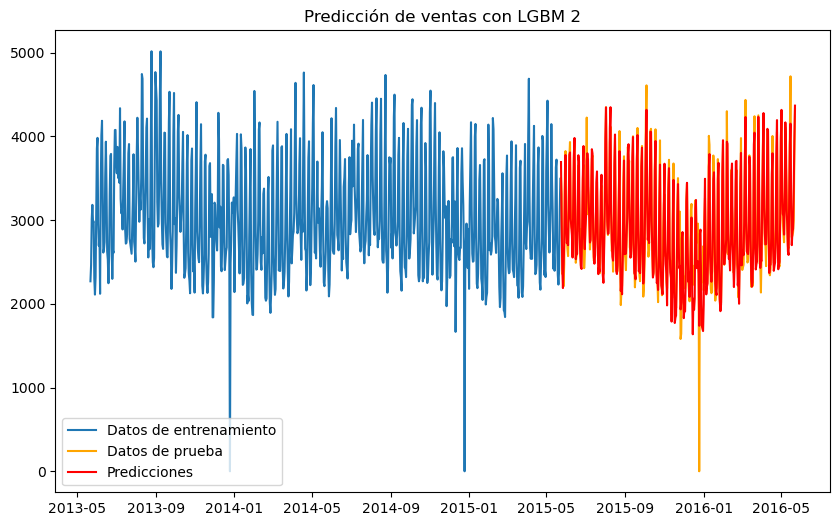

In [47]:
# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones del modelo
plt.plot(test.index, predicciones_finales, label='Predicciones', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas con LGBM 2')
plt.legend()
plt.show()

In [48]:
# Paso 10: Evaluar el rendimiento del modelo
mae_final = mean_absolute_error(y_test, predicciones_finales)
rmse_final = np.sqrt(mean_squared_error(y_test, predicciones_finales))

print(f'MAE final: {mae_final}')
print(f'RMSE final: {rmse_final}')

MAE final: 149.3719214796835
RMSE final: 217.45375431253106


In [49]:
# Obtener la importancia de las características del modelo entrenado
importancia_features = best_model.feature_importances_
features = X_train.columns

# Crear un DataFrame con los resultados
importancia_df = pd.DataFrame({'Feature': features, 'Importance': importancia_features})

# Ordenar por importancia
importancia_df = importancia_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importancia_df)

                      Feature  Importance
14  sales_weighted_moving_avg         379
6            sales_moving_avg         286
3                 sales_lag_2         279
2                 sales_lag_1         267
16                sales_lag_7         223
12               day_of_month         193
5                week_of_year         180
15   monthly_cumulative_sales         173
9                 day_of_week         147
10           price_volatility         119
8            cumulative_sales         114
0                  sell_price         104
4                       month          99
7     price_promo_interaction          34
13                 is_weekend          10
1                     snap_CA           8
11                    quarter           7


In [50]:
#Guardar las predicciones en una variable
predicciones = best_model.predict(X_test)

## **Evaluar y validar el modelo predictivo**

In [52]:
# Validación cruzada de 5 pliegues
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir los resultados a RMSE y mostrar por pliegue
rmse_scores = np.sqrt(-scores)
print(f'RMSE por pliegue: {rmse_scores}')
print(f'RMSE promedio: {rmse_scores.mean()}')

RMSE por pliegue: [260.18865589 262.07379808 218.10074577 243.25275655 215.80956875]
RMSE promedio: 239.8851050060851


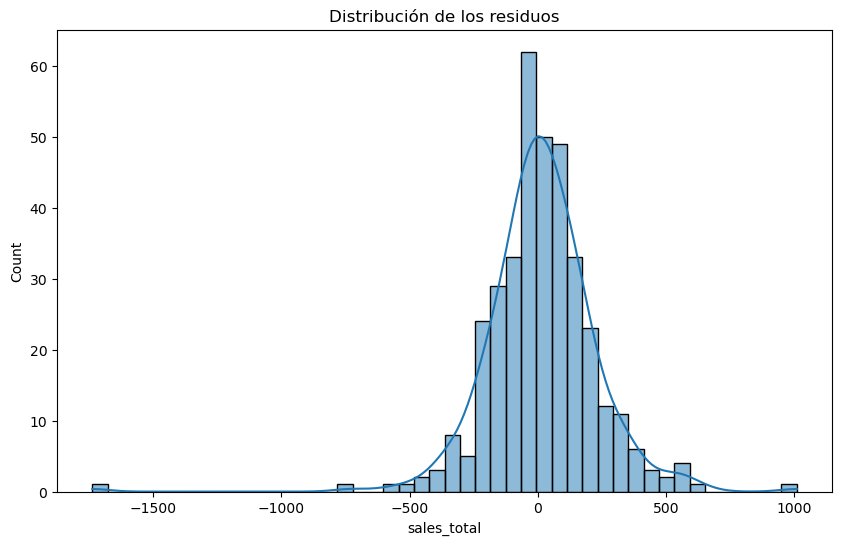

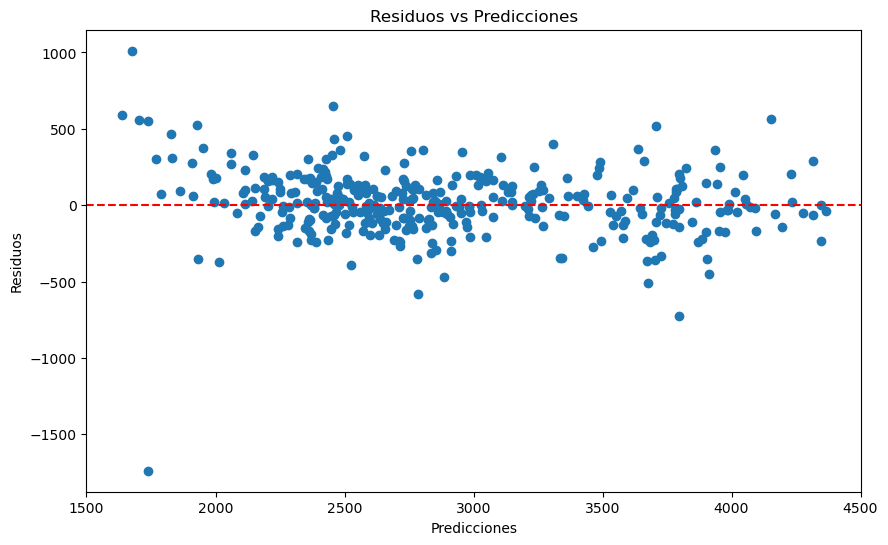

In [53]:
# Calcular los residuos
residuos = y_test - predicciones

# Graficar la distribución de los residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de los residuos')
plt.show()

# Graficar residuos vs predicciones
plt.figure(figsize=(10, 6))
plt.scatter(predicciones, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos vs Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.show()

In [54]:
# Evaluar rendimiento en el conjunto de entrenamiento
train_predicciones = best_model.predict(X_train)
mae_train = mean_absolute_error(y_train, train_predicciones)
rmse_train = np.sqrt(mean_squared_error(y_train, train_predicciones))

# Evaluar rendimiento en el conjunto de prueba
mae_test = mean_absolute_error(y_test, predicciones)
rmse_test = np.sqrt(mean_squared_error(y_test, predicciones))

print(f'Rendimiento en Entrenamiento - MAE: {mae_train}, RMSE: {rmse_train}')
print(f'Rendimiento en Prueba - MAE: {mae_test}, RMSE: {rmse_test}')

Rendimiento en Entrenamiento - MAE: 56.95089108178542, RMSE: 78.73660495072549
Rendimiento en Prueba - MAE: 149.3719214796835, RMSE: 217.45375431253106


## **Post-procesamiento del modelo predictivo: ajustar día de cierre de la tienda el 25 de diciembre con ventas 0**

In [56]:
# Crear una copia de las predicciones para no alterar las originales, convirtiéndolas a pandas Series con el índice de test
predicciones_ajustadas = pd.Series(predicciones_finales, index=test.index)

# Asegurarse de que las fechas de cierre estén en el conjunto de prueba
# En lugar de usar el índice original, nos basamos en el índice del conjunto de prueba (test)
dias_cierre = test[(test.index.month == 12) & (test.index.day == 25)].index

# Ajustar las predicciones a 0 en esos días específicos
predicciones_ajustadas.loc[dias_cierre] = 0

# Mostrar las predicciones ajustadas para verificar
print(predicciones_ajustadas[dias_cierre])

date
2015-12-25    0.0
dtype: float64


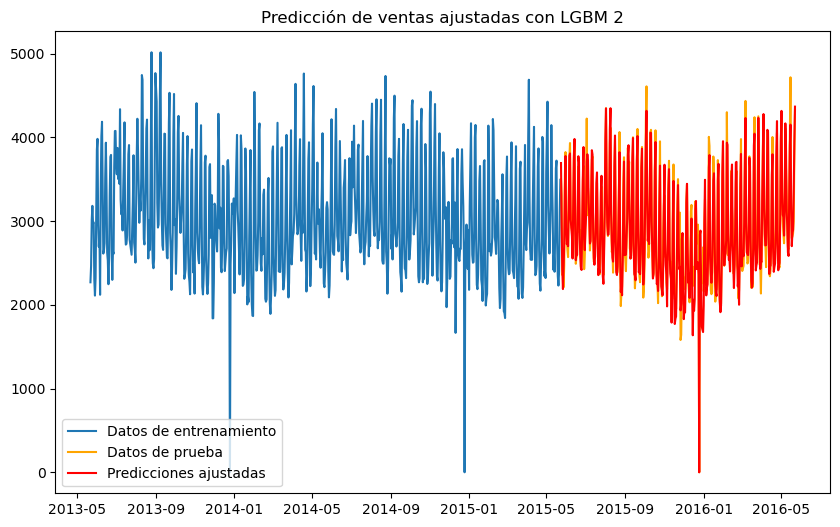

In [57]:
# Graficar los resultados después del ajuste
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones ajustadas
plt.plot(test.index, predicciones_ajustadas, label='Predicciones ajustadas', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas ajustadas con LGBM 2')
plt.legend()
plt.show()

In [58]:
# Calcular el MAE y RMSE para las predicciones ajustadas
mae_ajustado = mean_absolute_error(y_test, predicciones_ajustadas)
rmse_ajustado = np.sqrt(mean_squared_error(y_test, predicciones_ajustadas))

# Mostrar los resultados
print(f'MAE ajustado: {mae_ajustado}')
print(f'RMSE ajustado: {rmse_ajustado}')

MAE ajustado: 144.61004195604582
RMSE ajustado: 197.50842768468416


In [59]:
# Guardar modelo
joblib.dump(best_model, "categoria_model.pkl")

['categoria_model.pkl']